<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/6thWeekTask/DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ==================== 1. Import Library ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# ==================== 2. Load & Preprocessing ====================
# Load JSON Lines
df = pd.read_json("sample_data/DeteksiSarkasme.json", lines=True)

# Gunakan hanya kolom 'headline' dan 'is_sarcastic'
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])

X = pad_sequences(sequences, maxlen=200)
y = df['is_sarcastic'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **RNN (Recurrent Neural Network)**

### Persamaan:

Untuk setiap waktu ke-$$t$$:

$$
h_t = \tanh\bigl(W_{xh} x_t + W_{hh} h_{t-1} + b_h\bigr)
$$

$$
y_t = W_{hy} h_t + b_y
$$

### 📘 Penjelasan Variabel:

| Simbol     | Keterangan                               |
|------------|------------------------------------------|
| $$x_t$$    | Input pada waktu ke-$$t$$                |
| $$h_{t-1}$$| Hidden state dari waktu sebelumnya       |
| $$h_t$$    | Hidden state pada waktu ke-$$t$$         |
| $$y_t$$    | Output model pada waktu ke-$$t$$         |
| $$W_{xh}$$ | Bobot dari input ke hidden               |
| $$W_{hh}$$ | Bobot dari hidden ke hidden              |
| $$W_{hy}$$ | Bobot dari hidden ke output              |
| $$b_h$$    | Bias pada hidden                         |
| $$b_y$$    | Bias pada output                         |
| $$\tanh$$  | Fungsi aktivasi non-linear               |


In [6]:
# ==================== 3. RNN Model ====================
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=5000, output_dim=100, input_length=200))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=10, batch_size=128, callbacks=[EarlyStopping(patience=2)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6592 - loss: 0.5959 - val_accuracy: 0.8414 - val_loss: 0.3497
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8923 - loss: 0.2696 - val_accuracy: 0.8568 - val_loss: 0.3339
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9340 - loss: 0.1791 - val_accuracy: 0.8458 - val_loss: 0.3573
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7569 - loss: 0.5305 - val_accuracy: 0.8336 - val_loss: 0.4218


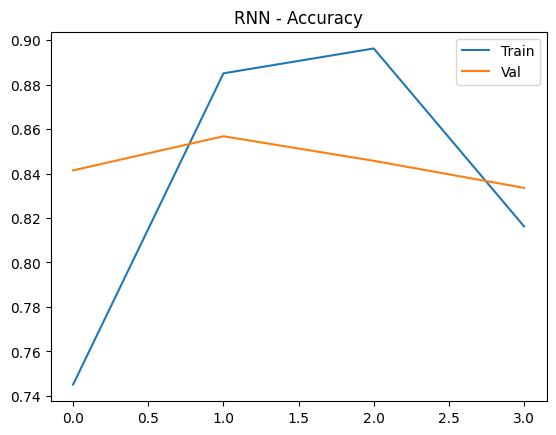

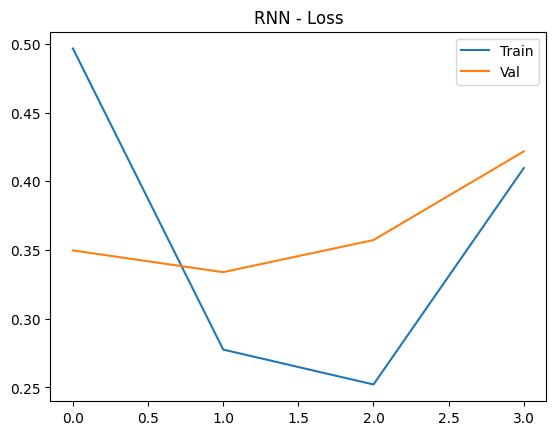

In [7]:
# Plot Akurasi dan Loss
plt.plot(history_rnn.history['accuracy'], label='Train')
plt.plot(history_rnn.history['val_accuracy'], label='Val')
plt.title("RNN - Accuracy")
plt.legend()
plt.show()

plt.plot(history_rnn.history['loss'], label='Train')
plt.plot(history_rnn.history['val_loss'], label='Val')
plt.title("RNN - Loss")
plt.legend()
plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
RNN Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      2996
           1       0.87      0.73      0.79      2346

    accuracy                           0.83      5342
   macro avg       0.84      0.82      0.83      5342
weighted avg       0.84      0.83      0.83      5342

RNN AUC: 0.9080727272623799


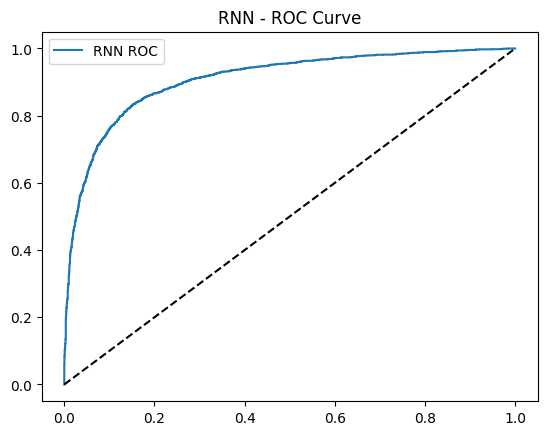

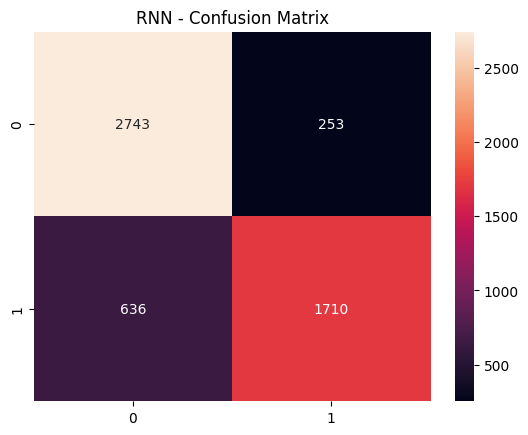

In [8]:
# Eval RNN
y_pred_prob = model_rnn.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("RNN Classification Report:\n", classification_report(y_test, y_pred))
print("RNN AUC:", roc_auc_score(y_test, y_pred_prob))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="RNN ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("RNN - ROC Curve")
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("RNN - Confusion Matrix")
plt.show()

## **LSTM (Long Short‑Term Memory)**

### Persamaan:

$$
\begin{aligned}
f_t &= \sigma\bigl(W_f x_t + U_f h_{t-1} + b_f\bigr)\\
i_t &= \sigma\bigl(W_i x_t + U_i h_{t-1} + b_i\bigr)\\
\tilde{c}_t &= \tanh\bigl(W_c x_t + U_c h_{t-1} + b_c\bigr)\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t\\
o_t &= \sigma\bigl(W_o x_t + U_o h_{t-1} + b_o\bigr)\\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$

### Penjelasan Variabel:

| Simbol           | Keterangan                                 |
|------------------|--------------------------------------------|
| $$f_t$$          | Forget gate                                |
| $$i_t$$          | Input gate                                 |
| $$\tilde{c}_t$$  | Kandidat memori baru                       |
| $$c_t$$          | Cell state (memori jangka panjang)         |
| $$o_t$$          | Output gate                                |
| $$\sigma$$       | Fungsi sigmoid                             |
| $$\tanh$$        | Fungsi aktivasi tanh                       |
| $$\odot$$        | Perkalian elemen‑wise                      |


In [9]:
# ==================== 4. LSTM Model ====================
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=100, input_length=200))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=10, batch_size=128, callbacks=[EarlyStopping(patience=2)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6397 - loss: 0.6465 - val_accuracy: 0.7887 - val_loss: 0.4769
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8318 - loss: 0.4004 - val_accuracy: 0.8519 - val_loss: 0.3477
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8917 - loss: 0.2671 - val_accuracy: 0.8545 - val_loss: 0.3438
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9128 - loss: 0.2214 - val_accuracy: 0.8555 - val_loss: 0.3530
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9336 - loss: 0.1779 - val_accuracy: 0.8478 - val_loss: 0.3781


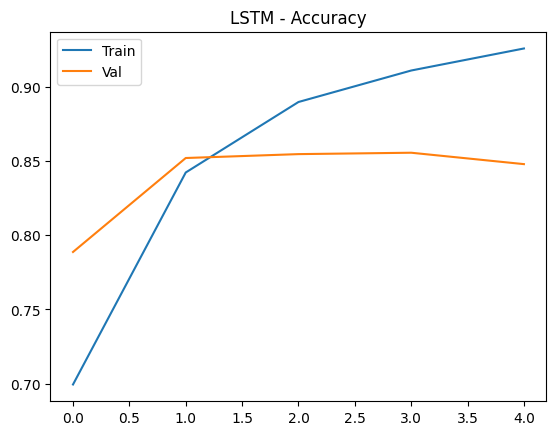

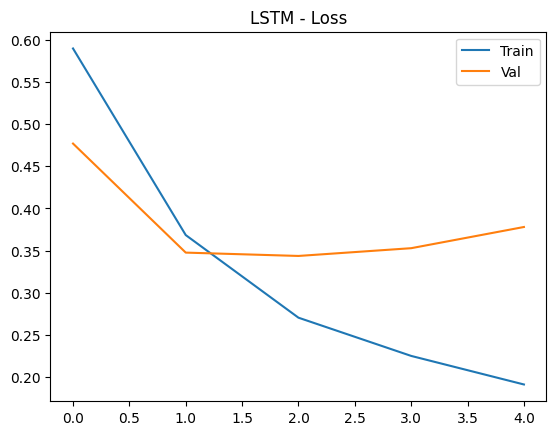

In [10]:
# Plot Akurasi dan Loss
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Val')
plt.title("LSTM - Accuracy")
plt.legend()
plt.show()

plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Val')
plt.title("LSTM - Loss")
plt.legend()
plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      2996
           1       0.80      0.88      0.84      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342

LSTM AUC: 0.930294811951599


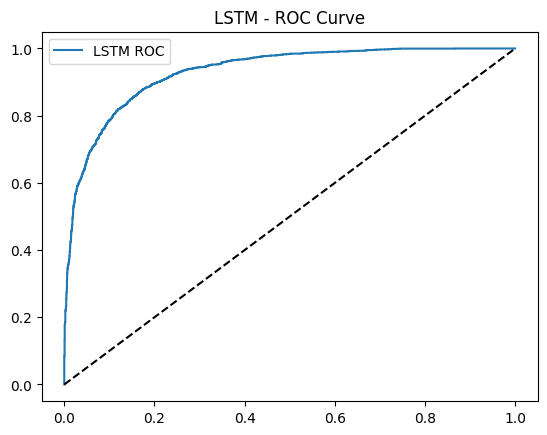

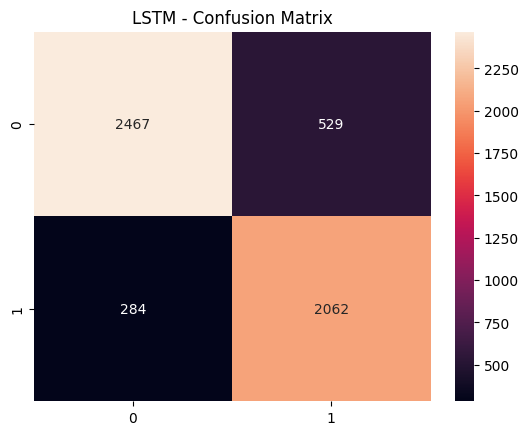

In [11]:
# Eval LSTM
y_pred_prob = model_lstm.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("LSTM Classification Report:\n", classification_report(y_test, y_pred))
print("LSTM AUC:", roc_auc_score(y_test, y_pred_prob))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="LSTM ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("LSTM - ROC Curve")
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("LSTM - Confusion Matrix")
plt.show()

## **GRU (Gated Recurrent Unit)**

### Persamaan:

$$
\begin{aligned}
z_t &= \sigma\bigl(W_z x_t + U_z h_{t-1} + b_z\bigr)\\
r_t &= \sigma\bigl(W_r x_t + U_r h_{t-1} + b_r\bigr)\\
\tilde{h}_t &= \tanh\bigl(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h\bigr)\\
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$$

### Penjelasan Variabel:

| Simbol          | Keterangan                           |
|-----------------|--------------------------------------|
| $$z_t$$         | Update gate                          |
| $$r_t$$         | Reset gate                           |
| $$\tilde{h}_t$$ | Kandidat hidden state                |
| $$h_t$$         | Hidden state akhir                   |
| $$\sigma$$      | Fungsi sigmoid                       |
| $$\tanh$$       | Fungsi aktivasi tanh                 |
| $$\odot$$       | Perkalian elemen‑wise                |

In [12]:
# ==================== 5. GRU Model ====================
model_gru = Sequential()
model_gru.add(Embedding(input_dim=5000, output_dim=100, input_length=200))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=10, batch_size=128, callbacks=[EarlyStopping(patience=2)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6558 - loss: 0.6790 - val_accuracy: 0.8351 - val_loss: 0.3732
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8793 - loss: 0.2940 - val_accuracy: 0.8613 - val_loss: 0.3297
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9239 - loss: 0.1994 - val_accuracy: 0.8559 - val_loss: 0.3480
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9460 - loss: 0.1517 - val_accuracy: 0.8547 - val_loss: 0.3763


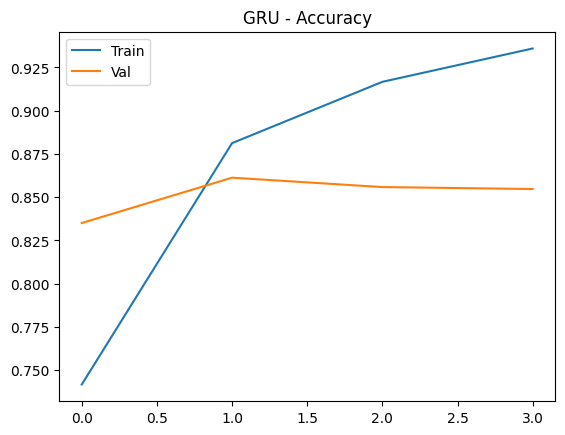

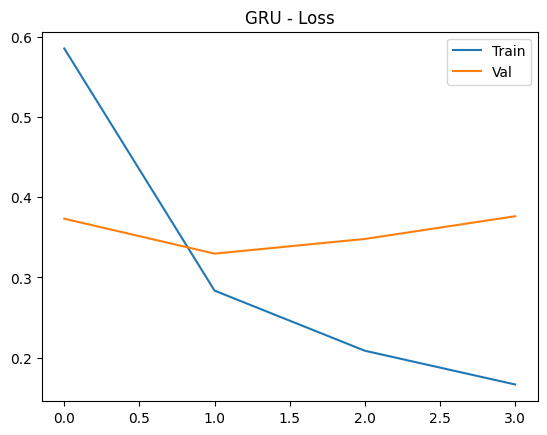

In [13]:
# Plot Akurasi dan Loss
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Val')
plt.title("GRU - Accuracy")
plt.legend()
plt.show()

plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Val')
plt.title("GRU - Loss")
plt.legend()
plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
GRU Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      2996
           1       0.84      0.83      0.83      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342

GRU AUC: 0.9299733404129632


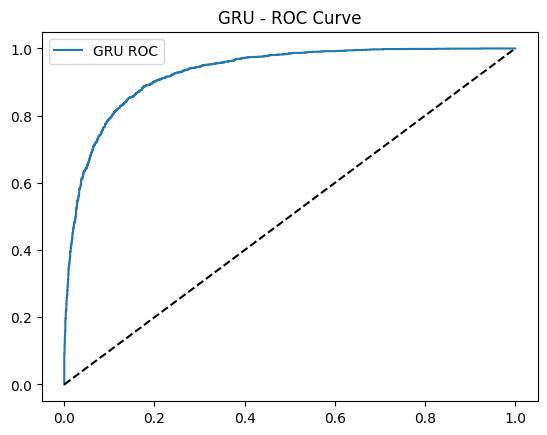

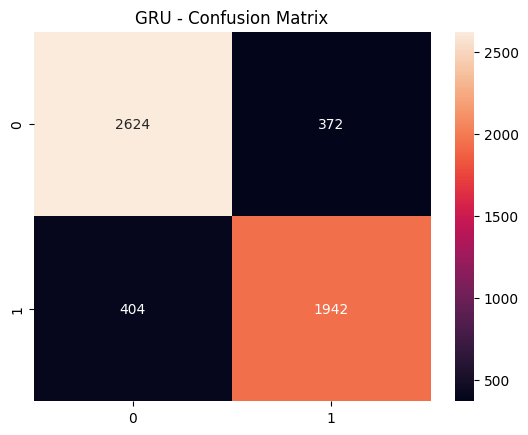

In [14]:
# Eval GRU
y_pred_prob = model_gru.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("GRU Classification Report:\n", classification_report(y_test, y_pred))
print("GRU AUC:", roc_auc_score(y_test, y_pred_prob))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="GRU ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("GRU - ROC Curve")
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("GRU - Confusion Matrix")
plt.show()

# **Kesimpulan**

Tiga model deep learning, yaitu RNN, LSTM, dan GRU, telah diuji untuk mendeteksi sarkasme pada teks berita. Berdasarkan hasil evaluasi, model LSTM menunjukkan performa terbaik dengan akurasi 85%, f1-score seimbang antar kelas, dan AUC tertinggi sebesar 0.93. LSTM unggul dalam mengenali konteks sarkastik yang kompleks berkat kemampuannya menangkap dependensi jangka panjang.

Model GRU juga mencatatkan performa yang sangat baik, dengan akurasi dan AUC hampir setara dengan LSTM, namun lebih efisien secara komputasi. Sementara itu, RNN menghasilkan akurasi yang lebih rendah (83%) dan memiliki kelemahan dalam mendeteksi kalimat sarkastik dengan baik, seperti tercermin dari recall yang lebih rendah.

Secara keseluruhan, LSTM direkomendasikan sebagai model utama untuk deteksi sarkasme, sementara GRU menjadi alternatif efisien dengan performa kompetitif.